### Bioscrape Lineages

# Example 1: The Bistable Toggle and Rules
## In this example, we will load the Bistable Toggle SBML Model made from BioCRNpyler and Simulate cell Growth and Division Using Rules

## _A cell will grow increasing volume and then divide in two, decreasing volume. Species can be partitioned using a VolumeSplitter. Available partitioning methods are:_
* "binomial"
* "perfect" (proportional to volume)
* "duplicate"
* "custom" (untested functionality for custom partitioning)

### Cells will grow at a constant rate using a "linear" volume rule. 

Other volume rules include: 
* __"multiplicative"__ (for exponentially growing volume)
* __"assignment"__ where the volume is set to any function (key "equation")
* __"ode"__ where $\frac{dV}{dt} = F(state, time)$ is integrated with a Eulers method

### Cells will divide deterministically whenever they have grown by an amount $\Delta$ using a "deltaV" division rule
* Each division rule may have its own, unique, volume splitter

Other division rules include:
* "__time__" where a cell will divide ever $T$ time (key "threshold"). 
* "__volume__" where a cell will divide at some volume threshold (key "threshold").
* "__general__" where a cell divides if a general algebraic expression (key "equation") is greater than 0.

### Cells can also die deterministically using death rules, but we have not used these in the model.
Possible death rules include:
* "__species__" where the cell will die if a certain species (key "species") is ">", "<", or "=" (key "comp") to a threshold (key "threshold").
* "__param__" which is like a species death rule, but for a certain parameter (key "param").
* "__general__" which is like a general division rule.

In [1]:
from bioscrape.lineage import LineageModel, LineageVolumeSplitter #For building our Model
from bioscrape.lineage import py_SimulateCellLineage
import numpy as np
import pylab as plt
import time as pytime
from time import process_time 

#Load Toggle CRN

vsplit_options = {
    "default":"binomial",
    "volume":"binomial",
    "dna_lacI_tetR":"duplicate",
    "dna_tetR_lacI":"duplicate"
}
copy_number = 1
x0 = {"dna_lacI_tetR": copy_number, "dna_tetR_lacI":copy_number}
Mtoggle = LineageModel(sbml_filename = "ToggleCRN.sbml", initial_condition_dict = x0)

print("Species in Mtoggle", list(Mtoggle.get_species()))

g = .1
vsplit = LineageVolumeSplitter(Mtoggle, options = vsplit_options)
#Model Division and Volume with Deterministic Rules
Delta = 1
Mtoggle.create_division_rule("deltaV", {"threshold":Delta}, vsplit)
Mtoggle.create_volume_rule("linear", {"growth_rate":g})

Species in Mtoggle ['protein_lacI', 'dna_lacI_tetR', 'protein_tetR', 'rna_lacI_tetR', 'dna_tetR_lacI', 'rna_tetR_lacI']


/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/bioscrape/sbmlutil.py:209: UserWarning: Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. Refer to the bioscrape wiki for more information.
  warnings.warn('Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. ' +


In [2]:
#Do the simulation!
timepoints = np.linspace(0, 100, 100)
print("Simulating")
ts = process_time()
lineage = py_SimulateCellLineage(timepoints = timepoints, Model = Mtoggle)
te = process_time()
print("Simulation Complete in", te-ts, "s")

#Lineage objects effectively trees. They contain a are lists of Schnitzes, each with a parent and 2 daughters (which could be none)

#For analysis and plotting purposes, it can be effective to use the function get_schnitzes_by_generation
#this returns a list of lists where the ith entry is a list of all Schnitzes of generation i
sch_tree = lineage.get_schnitzes_by_generation()
print("Total Cells Simulated = ", sum([len(L) for L in sch_tree]),"\nCells of each generation:", [len(L) for L in sch_tree], )

Simulating
Simulation Complete in 0.054070000000000285 s
Total Cells Simulated =  1023 
Cells of each generation: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]


/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Uninitialized Model Passed into ModelCSimInterface. Model.py_initialize() called automatically.
  """


Plotting


Text(0, 0.5, 'LacI - TetR')

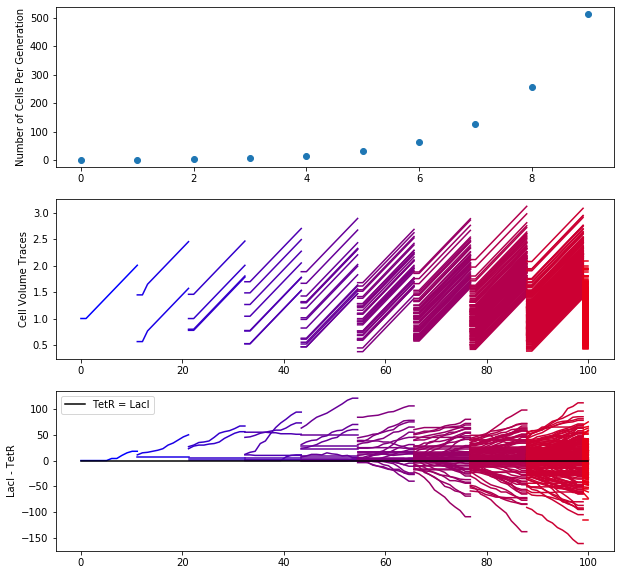

In [3]:
# A little plotting
color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

print("Plotting")
plt.figure(figsize = (10, 10))
#Plot Generation Counts
plt.subplot(311)
plt.plot(range(len(sch_tree)), [len(L) for L in sch_tree], "o")
plt.ylabel("Number of Cells Per Generation")

#Plot Volume Traces
plt.subplot(312)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = Mtoggle)
        plt.plot(df["time"], df["volume"], color = color_list[generation])
plt.ylabel("Cell Volume Traces")

#Plot lacI
plt.subplot(313)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = Mtoggle)
        plt.plot(df["time"], df["protein_lacI"] - df["protein_tetR"], color = color_list[generation])

plt.plot(timepoints, np.zeros(len(timepoints)), ms = "5", color = "black", label = "TetR = LacI")
plt.legend()
plt.ylabel("LacI - TetR")


> bistability of toggle blurs out because adding in division and cell growth (difft from one cell bioscrape model)

# Example 2: The Repressilator and Events
## In this example, we will load the Repessillator SBML Model made from BioCRNpyler and Simulate Cell Growth, Death, and Division Stochastically Using Events

### _Events are like reactions - they fire based upon Propensity functions - but cause Growth, Division, or Death instead of changes of Species counts._
* Events can use any of the propensity types available to reactions



### Cells will grow stochastically using a "linear" with a constant "massaction" propensity (Note this means growth rate will scale linearly with cell Volume)
Other volume events include: 
* __"multiplicative"__ (for exponentially growing volume)
* __"general"__ where the volume is set to any function (key "equation")

### Cells will divide stochastically with a constant "massaction" propensity (Note this means division rate will scale linearly with cell Volume)
* Each division event may have its own, unique, volume splitter


### Cells will die stochastically with a "hillpositive" propensity of cl, lacI, and tetR
* Death destroys the cells


In [4]:
from bioscrape.lineage import LineageModel, LineageVolumeSplitter #For building our Model
from bioscrape.lineage import py_SimulateCellLineage
import numpy as np
import pylab as plt
import time as pytime
from time import process_time 

#Load Toggle CRN

vsplit_options = {
    "default":"binomial",
    "dna_lacI_tetR":"duplicate",
    "dna_tetR_cl":"duplicate",
    "dna_cl_lacI":"duplicate"
}
copy_number = 1
tetR0 = 100
x0 = {"dna_lacI_tetR": copy_number, "dna_tetR_cl":copy_number, "dna_cl_lacI":copy_number, "protein_tetR":tetR0}
Mrepressilator = LineageModel(sbml_filename = "RepressillatorCRN.sbml", initial_condition_dict = x0)
print("Species in Mtoggle", list(Mrepressilator.get_species()))

#Model Division and Volume with Stochastic Events
kgrow = 100.0
Kgrow = 100
g = .02
#Volume Event wasn't working for me today, does it work for you?
#Mrepressilator.create_volume_event("linear volume", {"growth_rate":g}, "massaction", {"k":kgrow, "species":""})
Mrepressilator.create_volume_rule("linear", {"growth_rate":g})

kdivide = 0.006
vsplit = LineageVolumeSplitter(Mrepressilator, options = vsplit_options)
# as you get bigger, you are more likely to divide
Mrepressilator.create_division_event("division", {}, "massaction", {"k":kdivide, "species":""}, vsplit)

kdeath = .001
Kdeath = 50
## too much of any of the repressors, you may die
Mrepressilator.create_death_event("death", {}, "hillpositive", {"k":kdeath, "n":2,"s1":"protein_cl", "K":Kdeath})
Mrepressilator.create_death_event("death", {}, "hillpositive", {"k":kdeath, "n":2,"s1":"protein_lacI", "K":Kdeath})
Mrepressilator.create_death_event("death", {}, "hillpositive", {"k":kdeath, "n":2,"s1":"protein_tetR", "K":Kdeath})

Species in Mtoggle ['protein_lacI', 'dna_lacI_tetR', 'protein_tetR', 'rna_lacI_tetR', 'rna_tetR_cl', 'dna_tetR_cl', 'protein_cl', 'rna_cl_lacI', 'dna_cl_lacI']


/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/bioscrape/sbmlutil.py:209: UserWarning: Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. Refer to the bioscrape wiki for more information.
  warnings.warn('Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. ' +


In [5]:
#Do the simulation!
timepoints = np.linspace(0, 500, 500)
print("Simulating")
ts = process_time()
lineage = py_SimulateCellLineage(timepoints = timepoints, Model = Mrepressilator)
te = process_time()
print("Simulation Complete in", te-ts, "s")

#Lineage objects effectively trees. They contain a are lists of Schnitzes, each with a parent and 2 daughters (which could be none)

#For analysis and plotting purposes, it can be effective to use the function get_schnitzes_by_generation
#this returns a list of lists where the ith entry is a list of all Schnitzes of generation i
sch_tree = lineage.get_schnitzes_by_generation()
print("Total Cells Simulated = ", sum([len(L) for L in sch_tree]),"\nCells of each generation:", [len(L) for L in sch_tree], )

Simulating
Simulation Complete in 0.026154999999999262 s
Total Cells Simulated =  283 
Cells of each generation: [1, 2, 4, 8, 14, 28, 50, 64, 58, 36, 12, 6]


/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Uninitialized Model Passed into ModelCSimInterface. Model.py_initialize() called automatically.
  """


Plotting


Text(0, 0.5, 'Protein cl')

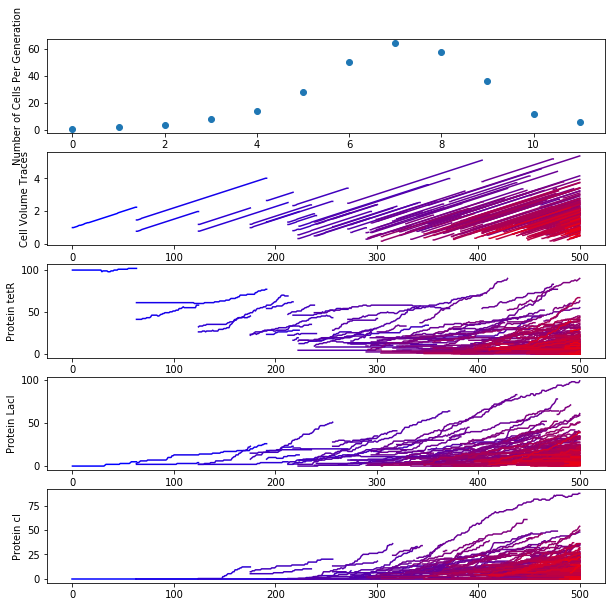

In [6]:
# A little plotting
color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

print("Plotting")
plt.figure(figsize = (10, 10))
#Plot Generation Counts
plt.subplot(511)
plt.plot(range(len(sch_tree)), [len(L) for L in sch_tree], "o")
plt.ylabel("Number of Cells Per Generation")

#Plot Volume Traces
plt.subplot(512)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = Mrepressilator)
        plt.plot(df["time"], df["volume"], color = color_list[generation])
plt.ylabel("Cell Volume Traces")


#Plot tetR
plt.subplot(513)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = Mrepressilator)
        plt.plot(df["time"], df["protein_tetR"], color = color_list[generation])
plt.ylabel("Protein tetR")

#Plot lacI
plt.subplot(514)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = Mrepressilator)
        plt.plot(df["time"], df["protein_lacI"], color = color_list[generation])
plt.ylabel("Protein LacI")

#Plot cl
plt.subplot(515)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = Mrepressilator)
        plt.plot(df["time"], df["protein_cl"], color = color_list[generation])
plt.ylabel("Protein cl")

### Tracking a Single Cell Lineage Trace Can be More Efficient and Insightful Than the Entire Ensemble
#### How it Works:
* Every division, one of the daughter cells is randomly discarded!

Simulating
Simulation Complete in 0.009972999999998677 s


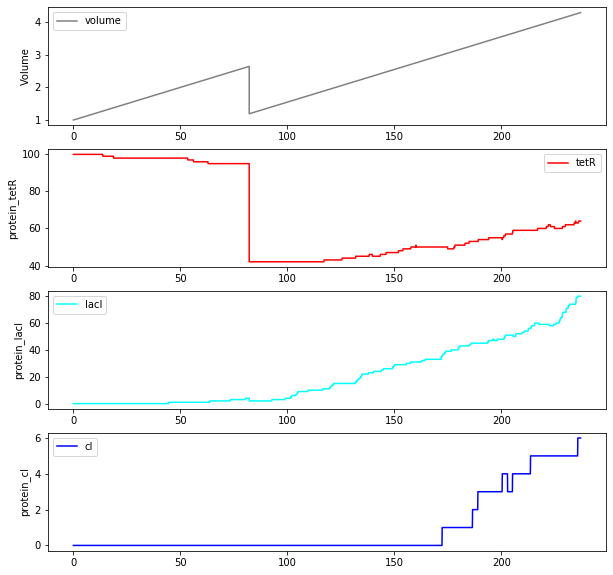

In [7]:
from bioscrape.lineage import py_SingleCellLineage
timepoints = np.linspace(0, 1000, 10000)
print("Simulating")
ts = process_time()
result_df = py_SingleCellLineage(timepoints = timepoints, Model = Mrepressilator)
te = process_time()
print("Simulation Complete in", te-ts, "s")

plt.figure(figsize = (10, 10))
plt.subplot(411)
plt.ylabel("Volume")
plt.plot(result_df["time"], result_df["volume"], label = "volume", color = "gray")
plt.legend()
plt.subplot(412)
plt.ylabel("protein_tetR")
plt.plot(result_df["time"], result_df["protein_tetR"], label = "tetR", color = "red")
plt.legend()
plt.subplot(413)
plt.ylabel("protein_lacI")
plt.plot(result_df["time"], result_df["protein_lacI"], label = "lacI", color = "cyan")
plt.legend()
plt.subplot(414)
plt.ylabel("protein_cl")
plt.plot(result_df["time"], result_df["protein_cl"], label = "cl", color = "blue")
plt.legend()

## Example 3: 2 Cell Types Interacting in their Environment

### Cell Type One Consumes Food (F) from the Environment and Produces Waste (W). It's growth rate is based on the amount of F. It dies if exposed to too much W.

### Cell Type 2 Consumes Waste (W) from the Environment. It's growth rate is based on the amount of W.

In [8]:
from bioscrape.lineage import LineageModel, LineageVolumeSplitter #For building our Model
from bioscrape.lineage import py_SimulateInteractingCellLineage, py_PropagateInteractingCells
from bioscrape.types import Model
import numpy as np
import pylab as plt
from time import process_time 

#A global mode with no reactions is just a container
global_x0 = {"W":0, "F":100}

#Add a food source
kf = 1.
rxng = [[], ["F"], "massaction", {"k":kf}]
x0g = {"F":0}
Mglobal = Model(species = ["F"], reactions = [rxng], initial_condition_dict = x0g)

#Use the Same Parameters for both cell types
ke = 1.
g = .01
kgrow = 100
Kgrow = 10
kdeath = 1.0
Kdeath = 100
x0 = {"E":5}

#cell type 1 consumes F (Food) to produce W (Waste) and E (internal machinery aka enzymes)
species = ["F","W", "E"]
rxn1 = [["F","E"], ["E","E","W"], "massaction", {"k":ke}]
Mcell1 = LineageModel(species = species, reactions = [rxn1], initial_condition_dict = x0)

vsplit = LineageVolumeSplitter(Mcell1)
Mcell1.create_division_rule("deltaV", {"threshold":1.0}, vsplit)
#E (enzymes) allow the cell to divide
Mcell1.create_volume_event("linear volume", {"growth_rate":g}, "hillpositive", {"k":kgrow, "s1":"E", "n":2, "K":Kgrow})
#Too much waste and the cell dies
Mcell1.create_death_event("death", {}, "hillpositive", {"k":kdeath, "s1":"W", "n":2, "K":Kdeath})

#Cell type 2 consumes W to produce E
species = ["W", "E"]
rxn2 = [["W","E"], ["E","E"], "massaction", {"k":ke}]
Mcell2 = LineageModel(species = species, reactions = [rxn1], initial_condition_dict = x0)


vsplit = LineageVolumeSplitter(Mcell2)
Mcell2.create_division_rule("deltaV", {"threshold":1.0}, vsplit)
Mcell2.create_volume_event("linear volume", {"growth_rate":g}, "hillpositive", {"k":kgrow, "s1":"E", "n":2, "K":Kgrow})
#too few enzymes and cell 2 two might die
Mcell2.create_death_event("death", {}, "hillnegative", {"k":.05*kdeath, "s1":"E", "n":4, "K":2})



/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: The following species are uninitialized and their value has been defaulted to 0: F, W, 
/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: The following species are uninitialized and their value has been defaulted to 0: W, F, 


In [9]:
maxtime = 20
dt = 0.01
global_sync_period = .5
global_volume = 100

timepoints = np.arange(0, maxtime+dt, dt)

average_dist_threshold = 2. # avg num of molecules per cell
global_species = ["F", "W"]
model_list = [Mcell1, Mcell2]
initial_cell_counts = [5, 5]

print("Simulating")
ts = process_time()
#Instead of simulating a whole cell Lineage, use propogate cells to get snapshots over time
lineage_list, global_results, simulator = py_SimulateInteractingCellLineage(timepoints, global_sync_period, global_volume = global_volume,
                                                 model_list = model_list, global_volume_model = Mglobal,
                                                 initial_cell_states = initial_cell_counts, 
                                                 global_species = global_species, 
                                                 average_dist_threshold = average_dist_threshold)

Nsamples = 10
# sample_list, sample_times, global_results, simulator = py_PropagateInteractingCells(timepoints, global_sync_period, 
#                                                  sample_times = Nsamples, global_volume = global_volume,
#                                                  model_list = model_list, global_volume_model = Mglobal,
#                                                  initial_cell_states = initial_cell_counts, 
#                                                  global_species = global_species, 
#                                                  average_dist_threshold = average_dist_threshold)
te = process_time()
print("Simulation Complete in", te-ts, "s")

print("N cell 1:", [len(L[0]) for L in sample_list])
print("N cell 2:", [len(L[1]) for L in sample_list])

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Global Species W not in global_volume_model. Species is being added to Model with initial condition 0.


Simulating


ValueError: Buffer dtype mismatch, expected 'int' but got 'long'

In [ ]:
print(global_results.py_get_result())
print("sample_times", sample_times)
plt.figure()
plt.subplot(211)
plt.title("Global Results")
plt.plot(sample_times, global_results.py_get_result()[1:, 0], label = "F")
plt.plot(sample_times, global_results.py_get_result()[1:, 1], label = "W")
plt.legend()

plt.subplot(212)
plt.plot(sample_times, [len(L[0]) for L in sample_list], label = "Cell Type 1")
plt.plot(sample_times, [len(L[1]) for L in sample_list], label = "Cell Type 2")
plt.legend()